<a href="https://colab.research.google.com/github/David-gutierrez-rodriguez/Simulacion-I/blob/main/Problema_de_inventarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo 5.5: Sistema de inventarios del libro de Coss, página 84

En general, es complicado obtener una solución analítica al problema, entonces, procedemos directamente a la simulación

In [1]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t as Tt

Se nos da la PDF de la demanda y del tiempo de entrega, así como los factores estacionales que afectan la demanda en función del mes

In [404]:
# PDF de la demanda de productos
def demanda():
  r = random()
  if r < 0.01: return 35
  elif 0.010 <= r and r < 0.025: return 36
  elif 0.025 <= r and r < 0.045: return 37
  elif 0.045 <= r and r < 0.065: return 38
  elif 0.065 <= r and r < 0.087: return 39
  elif 0.087 <= r and r < 0.110: return 40
  elif 0.110 <= r and r < 0.135: return 41
  elif 0.135 <= r and r < 0.162: return 42
  elif 0.162 <= r and r < 0.190: return 43
  elif 0.190 <= r and r < 0.219: return 44
  elif 0.219 <= r and r < 0.254: return 45
  elif 0.254 <= r and r < 0.299: return 46
  elif 0.299 <= r and r < 0.359: return 47
  elif 0.359 <= r and r < 0.424: return 48
  elif 0.424 <= r and r < 0.494: return 49
  elif 0.494 <= r and r < 0.574: return 50
  elif 0.574 <= r and r < 0.649: return 51
  elif 0.649 <= r and r < 0.719: return 52
  elif 0.719 <= r and r < 0.784: return 53
  elif 0.784 <= r and r < 0.844: return 54
  elif 0.844 <= r and r < 0.894: return 55
  elif 0.894 <= r and r < 0.934: return 56
  elif 0.934 <= r and r < 0.964: return 57
  elif 0.964 <= r and r < 0.980: return 58
  elif 0.980 <= r and r < 0.995: return 59
  else: return 60

# PDF del tiempo de entrega de los pedidos
def t():
  r = random()
  if r < 0.3: return 1
  elif 0.03 <= r and r < 0.7: return 2
  else: return 3

# Factor estacional en función del mes
def fact_est(n):
  return factores_estacionales[n - 1]

# Tuplas necesarias para ejecutar las funciones anteriores
factores_estacionales = (1.2, 1, 0.9, 0.8, 0.8, 0.7, 0.8, 0.9, 1, 1.2, 1.3, 1.4)
meses = ("Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre")

A continuación, se define la función inventario, la cual recibe como parámetros:


*   inventario_0: int. Inventario al inicio de la simulación
*   recompra: int. Si el inventario final es menor a $recompra$, se hace un pedido
*   compra: int. Cuando se hace un pedido, se hace una orden de $compra$ unidades
*   n: int. Número $n$ de años a simular

Y da como salida
*   data: DataFrame. Data frame de la simulación del primer año que contiene el inventario inicial, demanda ajustada, inventario final, faltante, órdenes e inventario mensual promedio de cada uno de los 12 meses del año
*   costos: DataFrame. Data frame que contiene el costo promedio de ordenar, de llevar inventario, de los faltantes y costo promedio total de la simulación de los $n$ años





In [412]:
def inventario(inventario_0, recompra, compra, n):
  # Listas que almacenarán los datos de las n simulaciones
  costo_ordenar = []
  costo_llevar_inventario = []
  costo_faltante = []
  costo_total = []

  for i in range(n):
    inventario_inicial = np.zeros(12, dtype = int)
    inventario_final = np.zeros(12, dtype = int)
    demanda_ajustada = np.zeros(12, dtype = int)
    faltante = np.zeros(12, dtype = int)
    orden = np.zeros(12, dtype = int)
    IMP = np.zeros(12, dtype = int)

    # Mes 1
    inventario_inicial[0] = inventario_0
    demanda_ajustada[0] = round(demanda()*fact_est(1))
    inventario_final[0] = inventario_0 - demanda_ajustada[0]
    IMP[0] = (inventario_inicial[0] + inventario_final[0])/2

    # Ordenar si se disminuyó por debajo del nivel de recompra
    if inventario_final[0] <= recompra:
      tiempo = t()
      perdiodo_sin_entrega = 0
      orden[0] = 1
      inventario_inicial[1 + tiempo] += compra

    # Siguientes 11 meses
    for mes in range(1, 12):
      # Cálculo del inventario inicial y demanda de cada mes
      inventario_inicial[mes] += inventario_final[mes - 1]
      demanda_ajustada[mes] += round(demanda()*fact_est(mes + 1), 0)

      # Faltante e inventario mensual promedio ajustados si hay faltantes
      if inventario_inicial[mes] < demanda_ajustada[mes]:
        faltante[mes] = demanda_ajustada[mes] - inventario_inicial[mes]
        IMP[mes] = (inventario_inicial[mes]**2)/(2*demanda_ajustada[mes])

        # Penalización por faltantes al momento en el que llega la mercancía
        if mes + tiempo - perdiodo_sin_entrega <= 11:
          inventario_inicial[mes + tiempo - perdiodo_sin_entrega] -= demanda_ajustada[mes] - inventario_inicial[mes]

      # Inventario final e inventario mensual promedio si no hay faltantes
      else:
        inventario_final[mes] = inventario_inicial[mes] - demanda_ajustada[mes]
        IMP[mes] = (inventario_inicial[mes] + inventario_final[mes])/2

      # Ordenar si se disminuyó por debajo del nivel de recompra, asegurándonos de
      # que no se haga un pedido si aún no ha llegado el pedido anterior
      # Condición si desde el primer mes (después de Enero) hay faltantes
      if sum(orden) == 0 and inventario_final[mes] <= recompra:
        tiempo = t()
        perdiodo_sin_entrega = 0
        orden[mes] = 1
        inventario_inicial[1 + mes + tiempo] += compra

      # Condición para el resto de casos mientras ya se haya entregado el
      # pedido anterior
      elif inventario_final[mes] <= recompra and tiempo <= perdiodo_sin_entrega:
        perdiodo_sin_entrega = 0
        orden[mes] += 1
        tiempo = t()

        if 1 + mes + tiempo <= 11:
          inventario_inicial[1 + mes + tiempo] += compra

      # Si no se entra en las condiciones anteriores, significa que aún no se
      # ha entregado el pedido, por eso, se aumenta en 1 el periodo sin entrega
      else:
        perdiodo_sin_entrega += 1

    # Se guardan los datos de la simulación del primer año
    if i == 0:
      data = pd.DataFrame({
          "Mes": meses,
          "Inventario Inicial" : inventario_inicial,
          "Demanda Ajustada" : demanda_ajustada,
          "Inventario Final" : inventario_final,
          "Faltante" : faltante,
          "Orden": orden,
          "IMP" : IMP
      })

    # Se añaden los datos de los costos para cada año de la simulación
    costo_ordenar.append(sum(orden)*100)
    costo_llevar_inventario.append(sum(IMP)*20/12)
    costo_faltante.append(sum(faltante)*50)
    costo_total.append(costo_ordenar[i] + costo_llevar_inventario[i] + costo_faltante[i])

  # Se guardan los costos promedio de todos los años de la simulación
  costos = pd.DataFrame({
      "CPxO": costo_ordenar,
      "CPxLI": costo_llevar_inventario,
      "CPF": costo_faltante,
      "CPT": costo_total
  })

  return data, costos

Simulación de 1 año con un inventario inicial de 150 unidades, un nivel de recompra de 100 unidades y una política de compra de 200 unidaes

,Mes,Inventario Inicial,Demanda Ajustada,Inventario Final,Faltante,Orden,IMP
0,Enero,150,65,85,0,1,117
1,Febrero,85,52,33,0,0,59
2,Marzo,33,50,0,17,0,10
3,Abril,183,45,138,0,0,160
4,Mayo,138,40,98,0,1,118
5,Junio,98,33,65,0,0,81
6,Julio,265,38,227,0,0,246
7,Agosto,227,48,179,0,0,203
8,Septiembre,179,46,133,0,0,156
9,Octubre,133,43,90,0,1,111


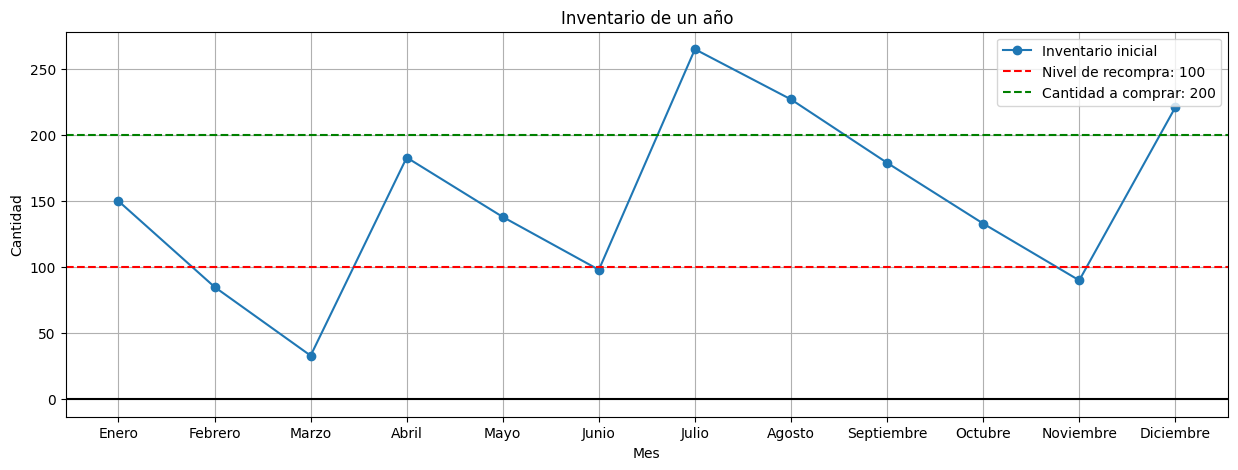

Costo por ordenar: $300.00
Costo por llevar inventario: $2,520.00
Costo por faltante: $850.00
Costo total: $3,670.00


In [413]:
inventario_0 = 150
recompra = 100
compra = 200

data, costos = inventario(inventario_0, recompra, compra, 1)

display(data)

plt.figure(figsize=(15, 5))
plt.plot(list(data["Inventario Inicial"]), marker = "o", label = "Inventario inicial")
plt.axhline(y = recompra, color = "r", linestyle = "--", label = f"Nivel de recompra: {recompra}")
plt.axhline(y = compra, color = "g", linestyle = "--", label = f"Cantidad a comprar: {compra}")
plt.axhline(y = 0, color = "k")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.title("Inventario de un año")
plt.legend(loc = "best")
plt.grid(True)
plt.xticks(range(12), meses)
plt.show()


print(f"Costo por ordenar: ${costos['CPxO'].mean():,.2f}")
print(f"Costo por llevar inventario: ${costos['CPxLI'].mean():,.2f}")
print(f"Costo por faltante: ${costos['CPF'].mean():,.2f}")
print(f"Costo total: ${costos['CPT'].mean():,.2f}")

Hacemos esta misma simulación, pero para 200 años, obteniendo el costo promedio total

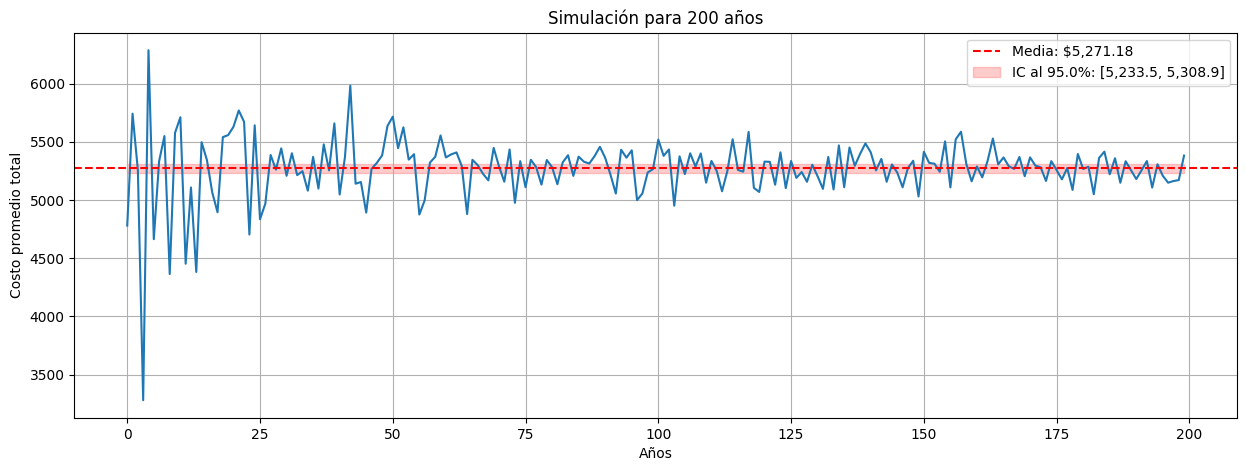

In [414]:
n = 200
x = []
for i in range(1, n + 1):
  _, costos = inventario(inventario_0, recompra, compra, i)
  x.append(np.mean(costos["CPT"]))


mu = np.mean(x)
s = np.std(x, ddof = 1)
alpha = 0.05
t_critico = Tt.ppf(1 - alpha/2, df = n - 2)
E = t_critico*s/np.sqrt(n)


plt.figure(figsize=(15, 5))
plt.plot(x)
plt.axhline(y = mu, color = "r", linestyle = "--", label = f"Media: ${mu:,.2f}")
plt.fill_between(range(n), mu - E, mu + E, color = "r", alpha = 0.2, label = f"IC al {(1-alpha)*100}%: [{(mu - E):,.1f}, {(mu + E):,.1f}]")
plt.xlabel("Años")
plt.ylabel("Costo promedio total")
plt.title(f"Simulación para {n} años")
plt.legend(loc = "best")
plt.grid(True)
plt.show()

Así, nos damos cuenta que con estas políticas, con una confianza del 95% se espera un costo total de entre $\$5,233.5$ y $\$5,308.9$

# Optimización usando el método de Hooke-Jeeaves
Usamos el método de Hooke-Jeeaves porque no se necesita la derivada de la función, a cambio, al método le toma un poco más converger a una solución óptima.\
El método se basa en tomar un punto inicial $x_0\in\mathbb{R}^2$ y calcular pequeñas variaciones $\Delta$ hacia atrás y adelante en cada una de las entradas del vector, si se encuentra una dirección de descenso, se calcula el siguiente $x_1$, en caso de no encontrar una mejor resultado, se disminuye la variación $\Delta$, hasta que se encuentre una dirección de descenso

In [408]:
# Función que simplifica la obtención del costo promedio total, haciendo 1000
# simulaciones y un inventario inicial de 150
def objetivo(x):
    recompra, compra = x
    _, costos = inventario(150, int(recompra), int(compra), 1000)
    return costos["CPT"].mean()

# Implementación del método
def hooke_jeeves(f, x0, delta = 10.0, epsilon = 1e-2, max_iter = 1000):
    x_base = x0[:]
    x_new = x0[:]
    n = len(x0)
    k = 0

    while delta > epsilon and k < max_iter:
        # Exploración
        for i in range(n):
            temp = x_new[i]

            x_new[i] += delta
            if f(x_new) >= f(x_base):
                x_new[i] = temp - delta
                if f(x_new) >= f(x_base):
                    x_new[i] = temp

        # Evaluar mejora
        if f(x_new) < f(x_base):
            x_pattern = [2*x_new[i] - x_base[i] for i in range(n)]
            if f(x_pattern) < f(x_new):
                x_base = x_new[:]
                x_new = x_pattern
            else:
                x_base = x_new[:]
        else:
            delta /= 2
            x_new = x_base[:]

        k += 1

    return [int(round(v)) for v in x_base], f(x_base)

Aplicando el método con el punto inicial $x_0 = (100, 200)$, se obtiene

In [409]:
x0 = [100, 200]
mejor_x, mejor_costo = hooke_jeeves(objetivo, x0)

In [415]:
print(f"Mejor nivel de recompra: {mejor_x[0]}")
print(f"Mejor compra: {mejor_x[1]}")
print(f"Costo promedio total mínimo: ${mejor_costo:,.1f}")

Mejor nivel de recompra: 159
Mejor compra: 232
Costo promedio total mínimo: $2,764.1


Ahora, hacemos la simulación de un año con los valores óptimos encontrados anteriormente:
- Inventario inicial = 150
- Recompra = 159
- Compra = 232

,Mes,Inventario Inicial,Demanda Ajustada,Inventario Final,Faltante,Orden,IMP
0,Enero,150,50,100,0,1,125
1,Febrero,100,48,52,0,0,50
2,Marzo,284,49,235,0,0,142
3,Abril,235,45,190,0,0,117
4,Mayo,190,38,152,0,1,95
5,Junio,152,32,120,0,0,76
6,Julio,120,38,82,0,0,60
7,Agosto,82,47,35,0,0,41
8,Septiembre,267,56,211,0,0,133
9,Octubre,211,67,144,0,1,105


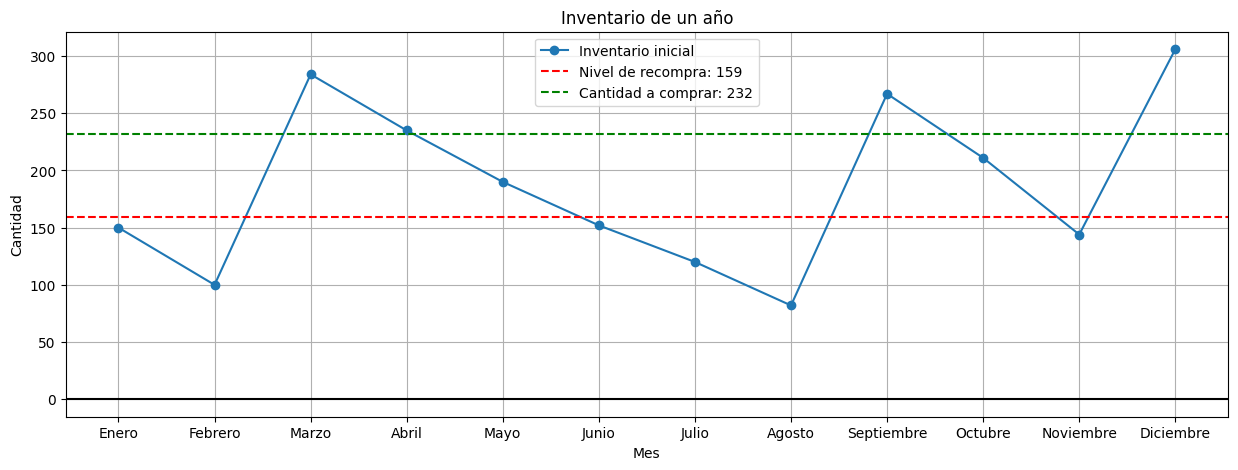

Costo por ordenar: $300.00
Costo por llevar inventario: $1,948.33
Costo por faltante: $0.00
Costo total: $2,248.33


In [411]:
inventario_0 = 150
recompra = mejor_x[0]
compra = mejor_x[1]

data, costos = inventario(inventario_0, recompra, compra, 1)

display(data)

plt.figure(figsize=(15, 5))
plt.plot(list(data["Inventario Inicial"]), marker = "o", label = "Inventario inicial")
plt.axhline(y = recompra, color = "r", linestyle = "--", label = f"Nivel de recompra: {recompra}")
plt.axhline(y = compra, color = "g", linestyle = "--", label = f"Cantidad a comprar: {compra}")
plt.axhline(y = 0, color = "k")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.title("Inventario de un año")
plt.legend(loc = "best")
plt.grid(True)
plt.xticks(range(12), meses)
plt.show()


print(f"Costo por ordenar: ${costos['CPxO'].mean():,.2f}")
print(f"Costo por llevar inventario: ${costos['CPxLI'].mean():,.2f}")
print(f"Costo por faltante: ${costos['CPF'].mean():,.2f}")
print(f"Costo total: ${costos['CPT'].mean():,.2f}")

Finalmente, hacemos la simulación para 200 años con los valores óptimos de las variables

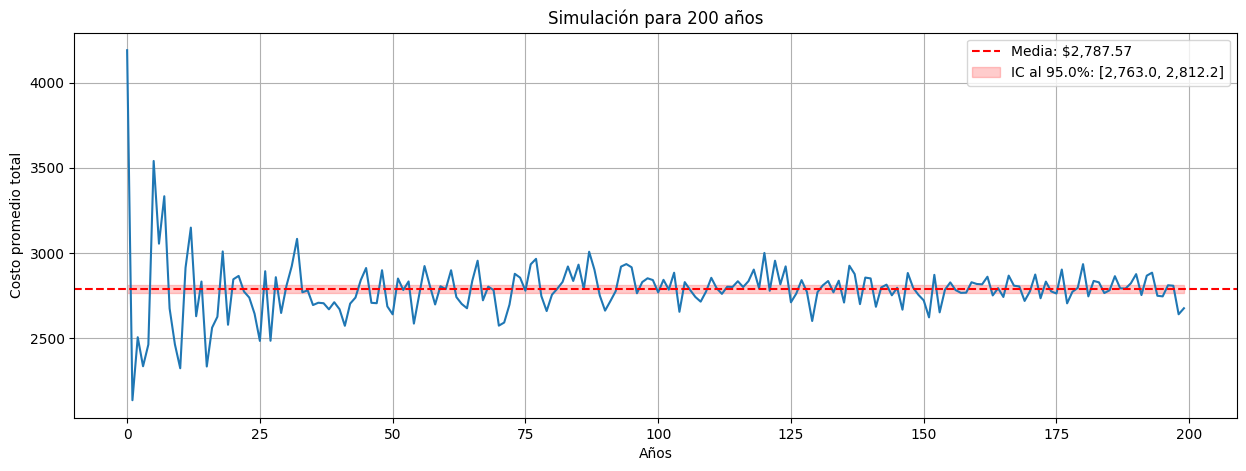

In [400]:
n = 200
x = []
for i in range(1, n + 1):
  _, costos = inventario(inventario_0, recompra, compra, i)
  x.append(np.mean(costos["CPT"]))


mu = np.mean(x)
s = np.std(x, ddof=1)
alpha = 0.05
t_critico = Tt.ppf(1 - alpha/2, df=n-2)
E = t_critico*s/np.sqrt(n)


plt.figure(figsize=(15, 5))
plt.plot(x)
plt.axhline(y = mu, color = 'r', linestyle = '--', label = f"Media: ${mu:,.2f}")
plt.fill_between(range(n), mu - E, mu + E, color = "r", alpha = 0.2, label = f"IC al {(1-alpha)*100}%: [{(mu - E):,.1f}, {(mu + E):,.1f}]")
plt.xlabel("Años")
plt.ylabel("Costo promedio total")
plt.title(f"Simulación para {n} años")
plt.legend(loc = "best")
plt.grid(True)
plt.show()

Así, concluímos que con una confianza del 95%, si se tiene una política de **recompra** de $159$ unidades y una **compra** de $232$ unidades, se espera tener costo total óptimo de entre $\$2,763$ y $\$2,812.2$